In [32]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float

import cv2
import numpy as np
from cv2 import ximgproc
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import math
import itertools
import operator
from skimage.feature import graycoprops
from skimage.feature import graycomatrix
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import aaa
import pickle
import math
from skimage import io, color
import numpy as np
from tqdm import trange
from extraction import *
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import binary_dilation

In [3]:
#DATA_PATH = "/Users/sunyiyou/cudi_research"
DATA_PATH = "/Volumes/NIH-AA/florian/graph_intermediate"
patient_id = "TULIP/AVL-061"

#bmode = aaa.load(os.path.join(DATA_PATH,patient_id,"bmode_texture_cropped_0.aaa"))
#ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_lowres_0_75_0.aaa"))
ceus_4d = aaa.load(os.path.join(DATA_PATH,patient_id,"ceus_texture_frames_cropped_0.aaa"))

print(ceus_4d.keys())
print(ceus_4d['data4d'].shape)

dict_keys(['voxel_size_mm', 'origin_mm', 'timestamps_s', 'dynamic_range_db', 'max_radius_mm', 'data4d', 'is_valid', 'type', 'scan_settings'])
(287, 224, 234, 20)


### 2D algorithm

Felzenszwalb number of segments: 79
SLIC number of segments: 98
SEEDs number of segments: 81
Quickshift number of segments: 142
Watershed number of segments: 100


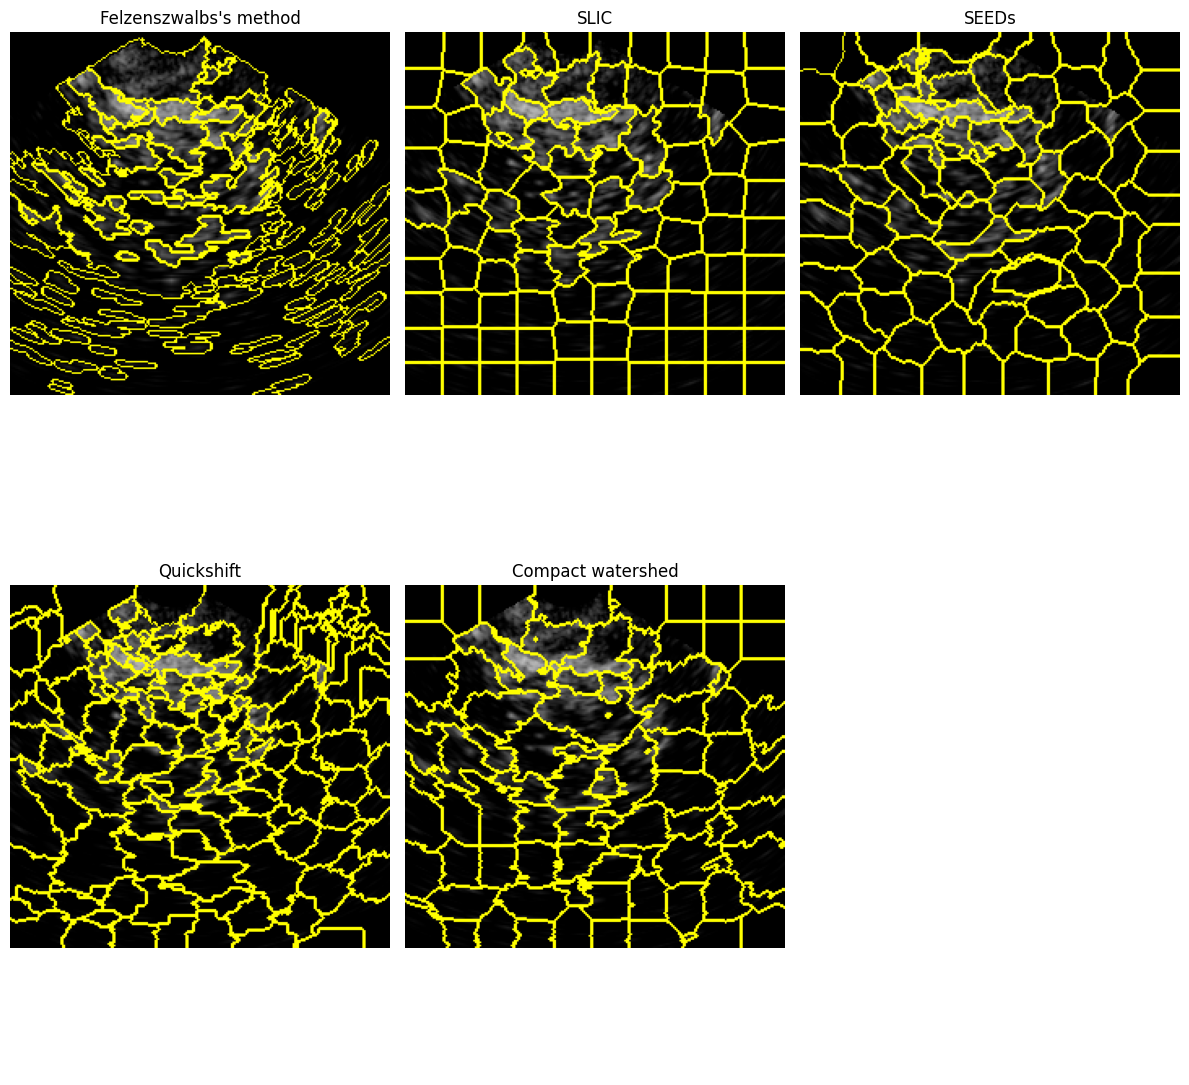

In [31]:
img = img_as_float(ceus_4d['data4d'][75,:,:,13])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50,channel_axis=None)
segments_slic = slic(img, n_segments=100, compactness=0.2, max_num_iter=10,sigma=1, start_label=1,channel_axis=None)
img = gray2rgb(img)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=100, compactness=0.001)

### SEEDs
img = np.array(ceus_4d['data4d'][75,:,:,13],dtype=np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
height,width,channels = converted_img.shape
seeds = ximgproc.createSuperpixelSEEDS(  width, height, channels, num_superpixels=150, num_levels=4, prior=2)
seeds.iterate(converted_img, 1000)
segments_seeds = seeds.getLabels() ### starting from 1 to record the segmentation
mask_seeds = seeds.getLabelContourMask(False)


print(f'Felzenszwalb number ofm segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'SEEDs number of segments: {seeds.getNumberOfSuperpixels()}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')



fig, ax = plt.subplots(2, 3, figsize=(12, 12), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[0, 2].imshow(mark_boundaries(img, segments_seeds))
ax[0, 2].set_title('SEEDs')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

### 3D implementation

In [25]:
img = img_as_float(ceus_4d['data4d'][:,:,:,13])

segments_slic_3d = slic(img, n_segments=250, compactness=0.1, max_num_iter=10,sigma=1, start_label=1,channel_axis=None)
gradient = sobel(img)
segments_watershed_3d = watershed(gradient, markers=250, compactness=0.001)




Text(0.5, 1.0, 'Compact watershed')

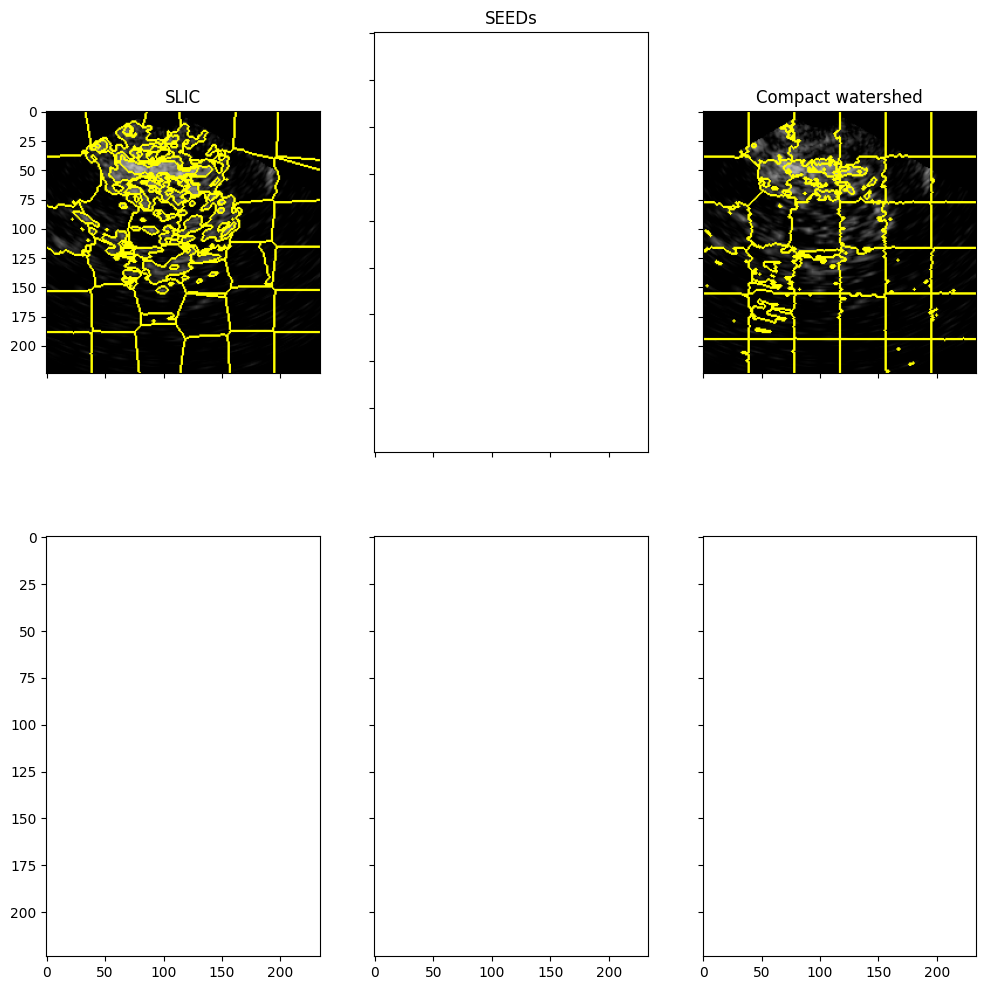

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(12, 12), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img[75,:,:], segments_slic_3d[75,:,:]))
ax[0, 0].set_title('SLIC')
#ax[0, 1].imshow(mark_boundaries(img[75,:,:], segments_seeds_3d[75,:,:]))
ax[0, 1].set_title('SEEDs')
ax[0, 2].imshow(mark_boundaries(img[75,:,:], segments_watershed_3d[75,:,:]))
ax[0, 2].set_title('Compact watershed')
